### Install the required pytorch libraries

In [1]:
!pip install torch torchvision

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils as tv_utils
from torch.utils.data.sampler import SubsetRandomSampler
from torch.nn.functional import softmax
import numpy as np
import matplotlib.pyplot as plt

# imports for inference function
from PIL import Image
import requests


### Load the data

In [3]:
# CIFAR-10 Data loading and transforming
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Load the training and test datasets
train_data = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)



100%|██████████| 170498071/170498071 [00:04<00:00, 41754055.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


#### Data preview and metatdata

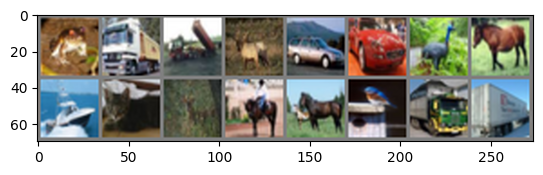

In [4]:
# CIFAR-10 classes
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Function to show an image
def show_image(img):
    img = img / 2 + 0.5  # Unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)), interpolation='spline36')
    plt.show()

# Get some random training images
dataiter = iter(torch.utils.data.DataLoader(train_data, batch_size=16))
images, labels = next(dataiter)

# Show images
show_image(tv_utils.make_grid(images))

# Print labels
print('Labels of the shown images:', ' '.join(f'{classes[labels[j]]}' for j in range(16)))

# Image dimensions and channels
# Since all images in CIFAR-10 have the same dimensions and number of channels,
# we can just check the first image in the batch.
image_shape = images[0].shape
print(f"Image dimensions (Channels x Height x Width): {image_shape}")
print(f"Number of channels: {image_shape[0]}")
print(f"Height: {image_shape[1]} pixels")
print(f"Width: {image_shape[2]} pixels")

# Print basic dataset metadata
print(f"Number of training images: {len(train_data)}")
print(f"Number of test images: {len(test_data)}")


Labels of the shown images: frog truck truck deer car car bird horse ship cat deer horse horse bird truck truck
Image dimensions (Channels x Height x Width): torch.Size([3, 32, 32])
Number of channels: 3
Height: 32 pixels
Width: 32 pixels
Number of training images: 50000
Number of test images: 10000


In [5]:
# Prepare data loaders
batch_size = 20
validation_split = 0.2
shuffle_dataset = True
random_seed= 42

# Creating data indices for training and validation splits:
dataset_size = len(train_data)
indices = list(range(dataset_size))
split = int(np.floor(validation_split * dataset_size))
if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
validation_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)

### Model architecture

In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()


        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 32, 3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.conv4 = nn.Conv2d(64, 64, 3, padding=1)
        self.bn4 = nn.BatchNorm2d(64)

        self.conv5 = nn.Conv2d(64, 128, 3, padding=1)
        self.bn5 = nn.BatchNorm2d(128)
        self.conv6 = nn.Conv2d(128, 128, 3, padding=1)
        self.bn6 = nn.BatchNorm2d(128)

        self.conv7 = nn.Conv2d(128, 256, 3, padding=1)
        self.bn7 = nn.BatchNorm2d(256)
        self.conv8 = nn.Conv2d(256, 256, 3, padding=1)
        self.bn8 = nn.BatchNorm2d(256)

        self.fc = nn.Linear(256 * 2 * 2, 10)

        self.dropout = nn.Dropout(0.5)

    def forward(self, x):
        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.2, training=self.training)
        x = F.relu(self.bn3(self.conv3(x)))
        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.3, training=self.training)
        x = F.relu(self.bn5(self.conv5(x)))
        x = F.relu(self.bn6(self.conv6(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.4, training=self.training)
        x = F.relu(self.bn7(self.conv7(x)))
        x = F.relu(self.bn8(self.conv8(x)))
        x = F.max_pool2d(x, 2)
        x = F.dropout(x, p=0.5, training=self.training)
        x = F.adaptive_avg_pool2d(x, (2, 2))
        x = torch.flatten(x, 1)
        x = self.fc(x)
        return x


In [7]:
# Check if CUDA is available and move the model to GPU if possible
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)



### Training Hyperparameters

In [8]:
# Number of epochs to train the model
n_epochs = 20
learning_rate = 0.001

# Specify the loss function and optimizer
ce_loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)


### Training Loop

In [9]:
# Track change in validation loss
valid_loss_min = np.Inf

for epoch in range(1, n_epochs+1):

    # Keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0

    # Train the model
    model.train()
    for data, target in train_loader:
        # Move tensors to the right device
        data, target = data.to(device), target.to(device)
        # Zero the gradients
        optimizer.zero_grad()
        # Forward pass
        output = model(data)
        # Calculate the loss
        loss = ce_loss(output, target)
        # Backward pass
        loss.backward()
        # Optimize
        optimizer.step()
        # Update training loss
        train_loss += loss.item()*data.size(0)

    # Validate the model
    model.eval()
    with torch.no_grad():
        for data, target in validation_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = ce_loss(output, target)
            valid_loss += loss.item()*data.size(0)

    # Calculate average losses
    train_loss = train_loss/len(train_loader.sampler)
    valid_loss = valid_loss/len(validation_loader.sampler)

    # Print training/validation statistics
    print(f'Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}')

    # Save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print(f'Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'model_cifar10.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 1.536062 	Validation Loss: 1.083206
Validation loss decreased (inf --> 1.083206).  Saving model ...
Epoch: 2 	Training Loss: 1.076510 	Validation Loss: 0.811441
Validation loss decreased (1.083206 --> 0.811441).  Saving model ...
Epoch: 3 	Training Loss: 0.887305 	Validation Loss: 0.732703
Validation loss decreased (0.811441 --> 0.732703).  Saving model ...
Epoch: 4 	Training Loss: 0.786419 	Validation Loss: 0.650501
Validation loss decreased (0.732703 --> 0.650501).  Saving model ...
Epoch: 5 	Training Loss: 0.708183 	Validation Loss: 0.623115
Validation loss decreased (0.650501 --> 0.623115).  Saving model ...
Epoch: 6 	Training Loss: 0.648009 	Validation Loss: 0.571741
Validation loss decreased (0.623115 --> 0.571741).  Saving model ...
Epoch: 7 	Training Loss: 0.611574 	Validation Loss: 0.538544
Validation loss decreased (0.571741 --> 0.538544).  Saving model ...
Epoch: 8 	Training Loss: 0.569182 	Validation Loss: 0.553875
Epoch: 9 	Training Loss: 0.536238 

### Test the model

In [10]:
# Load the best model
model.load_state_dict(torch.load('model_cifar10.pt'))

# Test the model
test_loss = 0.0
class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))

model.eval()
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        loss = ce_loss(output, target)
        test_loss += loss.item()*data.size(0)
        _, pred = torch.max(output, 1)
        correct = np.squeeze(pred.eq(target.data.view_as(pred)))
        for i in range(batch_size):
            label = target.data[i]
            class_correct[label] += correct[i].item()
            class_total[label] += 1

# Calculate and print avg test loss
test_loss = test_loss/len(test_loader.dataset)
print(f'Test Loss: {test_loss:.6f}\n')

for i in range(10):
    if class_total[i] > 0:
        print(f'Test Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]:.2f}% ({np.sum(class_correct[i])}/{np.sum(class_total[i])})')
    else:
        print(f'Test Accuracy of {classes[i]}: N/A (no training examples)')

print(f'\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total):.2f}% ({np.sum(class_correct)}/{np.sum(class_total)})')

Test Loss: 0.453802

Test Accuracy of plane: 87.20% (872.0/1000.0)
Test Accuracy of car: 92.80% (928.0/1000.0)
Test Accuracy of bird: 76.80% (768.0/1000.0)
Test Accuracy of cat: 68.50% (685.0/1000.0)
Test Accuracy of deer: 81.30% (813.0/1000.0)
Test Accuracy of dog: 82.80% (828.0/1000.0)
Test Accuracy of frog: 92.70% (927.0/1000.0)
Test Accuracy of horse: 86.10% (861.0/1000.0)
Test Accuracy of ship: 92.00% (920.0/1000.0)
Test Accuracy of truck: 92.30% (923.0/1000.0)

Test Accuracy (Overall): 85.25% (8525.0/10000.0)


### Inference with new data

In [11]:
def predict_image_class(image_url, model, device, classes):
    """
    Predict the class of an object in an image from a given URL.

    Parameters:
    - image_url: str. The URL of the image to predict.
    - model: PyTorch model. The trained model to use for the prediction.
    - device: torch.device. The device (CPU or GPU) the model is running on.
    - classes: list. A list of class names corresponding to the model's output.

    Returns:
    - A string containing the predicted class.
    """

    # Define the image transformation
    transform = transforms.Compose([
        transforms.Resize((32, 32)),  # Resize the image to 32x32 pixels
        transforms.ToTensor(),  # Convert the image to a PyTorch tensor
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # Normalize the image
    ])

    # Download the image
    response = requests.get(image_url, stream=True)
    image = Image.open(response.raw)

    plt.imshow(image)
    plt.axis('off')
    plt.show()

    # Preprocess the image
    image = transform(image).unsqueeze(0).to(device)  # Add a batch dimension and move to the device

    # Predict the class
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():  # Disable gradient calculation for inference
        outputs = model(image)
        probabilities = softmax(outputs, dim=1)
        predicted_class_idx = probabilities.argmax(dim=1).item()  # Get the index of the max probability

    # Return the predicted class
    return classes[predicted_class_idx], probabilities[0, predicted_class_idx].item()

### Run inference

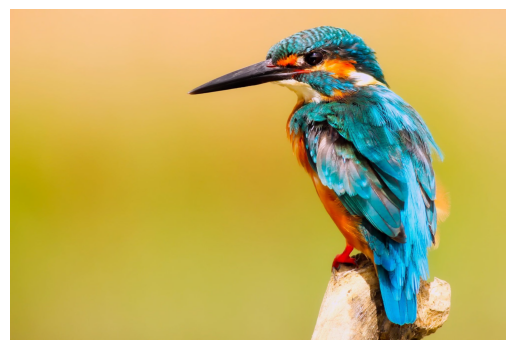

Predicted class: bird with confidence 1.00


In [20]:
# Image Credits> Creator: Matthew Clara | Credit: MI Dept. of Natural Resources
url_1 = "https://www.outdoornews.com/wp-content/uploads/2023/10/Deer_Doe-by-grass_Michigan-DNR-photo.jpg"

# Image Credits> Creator: Matthew Barra | Credit: Photo by Matthew Barra
url_2 = "https://images.pexels.com/photos/813011/pexels-photo-813011.jpeg"

# Image Credits> Creator: Pixabay | Credit: Photo by Pixabay
url_3 = "https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg"

image_url= url_3
predicted_class, confidence = predict_image_class(image_url, model, device, classes)
print(f"Predicted class: {predicted_class} with confidence {confidence:.2f}")